In [ ]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import cmudict
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('cmudict')
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import multiprocessing
import re
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
data = pd.read_csv("/content/drive/MyDrive/train.csv")
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.25, random_state=5)

In [3]:
x_train['score'] = y_train
x_train.head()

,essay_id,full_text,score
1360,1549de8,"Senator of the State of Florida,\n\nThe Electo...",5
1872,1caaf3f,"In America we have lots of cars, lots of roads...",3
11706,ac199a9,Computers shouldnt have to tell our emotions. ...,3
14234,d17dfc0,NASA has always knowen it was a simple rock fr...,2
8997,84ddd05,It's not a secret that we as humans use cars t...,5


In [26]:
def count_unique_words(df):
    """
    Counts the number of unique words on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    num_unique_words (int): Number of unique words in the DataFrame.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)

    return num_unique_words

def get_average_essay_length(df):
    """
    Calculates the average length of essays in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_length (float): Average length of essays in terms of word count.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_words = len(words)
    num_essays = len(df)
    average_length = total_words / num_essays

    return average_length

def calculate_average_word_length(df):
    """
    Calculates the average length of words used in the essays.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_word_length (float): Average length of words in the essays.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_characters = sum(len(word) for word in words)
    total_words = len(words)
    average_word_length = total_characters / total_words

    return average_word_length

def get_most_common_words(df, stopwords_not_included=True, num_words=10):
    """
    Identifies the most common words used in the essays along with their counts.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    stopwords (bool): Whether to include stopwords or not. If true, stopwords will be removed.
    num_words (int): Number of most common words to return.

    Returns:
    common_words (list of tuples): List of tuples containing the most common words and their counts.
    """
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()

    if (stopwords_not_included == True):
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]

    word_counts = Counter(words)
    common_words = word_counts.most_common(num_words)

    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
    print(df_common_words)

    return common_words

def syllable_count_word(word):
    """
    Counts the number of syllables in a word using the CMU Pronouncing Dictionary.

    Parameters:
    word (str): The word for which syllable count needs to be calculated.

    Returns:
    syllable_count (int): The number of syllables in the word.
    """

    d = cmudict.dict()

    if word in d:
        syllable_count = max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    else:
        syllable_count = 1

    return syllable_count

def calculate_fkgl(text):
    """
    Calculates the Flesch-Kincaid Grade Level (FKGL) score for a given text.

    Parameters:
    text (str): The text for which FKGL score needs to be calculated.

    Returns:
    fkgl_score (float): The FKGL score of the text.
    """

    sentences = sent_tokenize(text)
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]

    syllable_count = 0
    for word in words:
        syllable_count += syllable_count_word(word)

    average_sentence_length = len(words) / len(sentences)
    average_syllables_per_word = syllable_count / len(words)

    fkgl_score = 0.39 * average_sentence_length + 11.8 * average_syllables_per_word - 15.59

    return fkgl_score

def plot_essay_length_distribution(df):
    """
    Plots a histogram showing the distribution of essay lengths in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    essay_lengths = [len(words) for words in df['full_text'].str.split()]

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(essay_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Essay Lengths')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_scores_frequency(df):
    """
    Plots a pie chart showing the distribution of scores in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the scores.
    """
    scores = df['score'].value_counts()
    plt.figure(figsize=(12, 6))
    plt.pie(scores.values, labels=scores.index, autopct='%1.1f%%')
    plt.title('Score distribution')
    plt.show()


def plot_essay_length_and_scores(df):
    """
    Plots a scatter plot showing the relationship between essay length and scores.

    Parameters:
    df (DataFrame): DataFrame containing the essays and scores.
    """

    essay_lengths = [len(words) for words in df['full_text'].str.split()]

    plt.figure(figsize=(10, 6))
    plt.scatter(essay_lengths, df['score'], color='skyblue')
    plt.title('Essay Length vs. Score')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()



In [21]:
def data_preprocessing(df):

    for index, row in df.iterrows():
        text_value = row['full_text']

            # lowercasing
        text_value = text_value.lower()

            # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

            # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

            # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])

            # store the cleaned text
        df.at[index, 'text'] = text_value

    return df


In [46]:
train = data_preprocessing(x_train)
test = data_preprocessing(x_test)

Number of unique words in the dataset: 108346
Average essay length in the dataset: 367.5642526964561
Average word length in the dataset: 4.557779694922473
FKGL Score of The Australian platypus is seemingly a hybrid of a mammal and reptilian creature is 11.264615384615386

Most common words in the dataset:
     Word  Count
0   would  32458
1  people  23996
2    cars  23733
3     car  22660
4   could  21813
5    like  16755
6   Venus  16159
7     get  12987
8    also  12799
9   think  11611


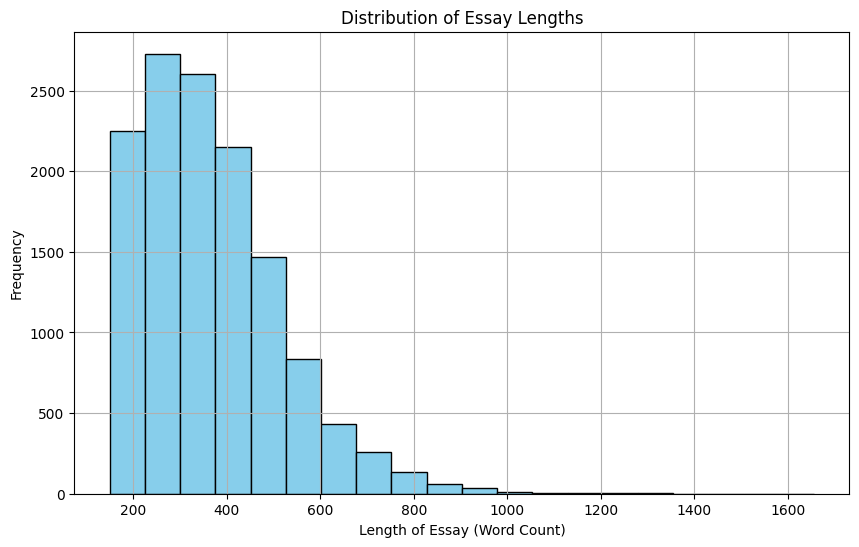

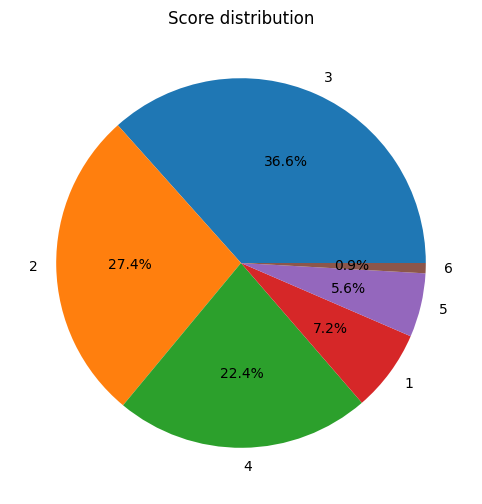

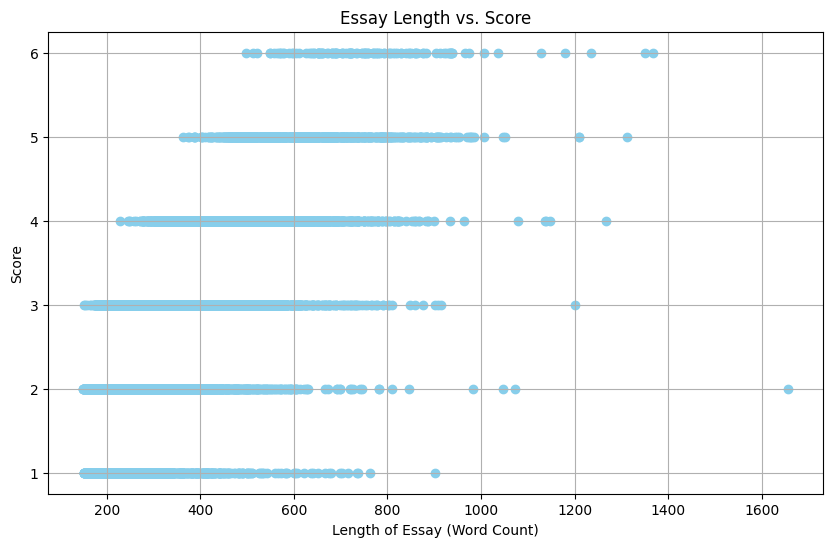

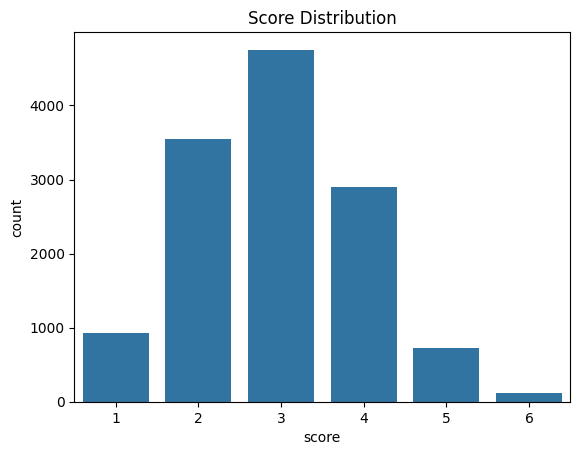

In [34]:
num_unique_words = count_unique_words(train)
average_essay_length = get_average_essay_length(train)
average_word_length = calculate_average_word_length(train)
print("Number of unique words in the dataset:", num_unique_words)
print("Average essay length in the dataset:", average_essay_length)
print("Average word length in the dataset:", average_word_length)
print("FKGL Score of The Australian platypus is seemingly a hybrid of a mammal and reptilian creature is" , calculate_fkgl("The Australian platypus is seemingly a hybrid of a mammal and reptilian creature"))
print("\nMost common words in the dataset:")
most_common_words = get_most_common_words(train)
plot_essay_length_distribution(train)
plot_scores_frequency(train)
plot_essay_length_and_scores(train)


In [35]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(1,1),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

In [54]:
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
test_tfid = vectorizer.transform([i for i in test['full_text']])

In [37]:
import lightgbm as lgb
model_lgbm = lgb.LGBMRegressor()

In [ ]:
from sklearn.metrics import cohen_kappa_score
a = 2.998
b = 1.092

def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return qwk


predictor = model_lgbm.fit(X = train_tfid,
                      y= train['score'].values,
                      eval_metric=quadratic_weighted_kappa
                      )



In [55]:
preds = predictor.predict(train_tfid).clip(1,6).round().astype(int)
cohen_kappa_score(y_train, preds, weights="quadratic")

0.6911708042854926

In [56]:
preds = predictor.predict(test_tfid).clip(1,6).round().astype(int)
cohen_kappa_score(y_test ,preds, weights="quadratic")

0.5396682083043951